In [ ]:
#| default_exp lhs

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# %pip install lark
# %pip install networkx
from lark import Lark

## LHS parser ##

parsing of the pattern sent as lhs, into a networkX graph representing the template to search.

The module converts the declerative constraints regarding the properties of the nodes and edges in the LHS, to imperative functions that are checked together with the 'condition' parameter

## grammar

In [ ]:
#| export
lhs_parser = Lark(r"""
    %import common.INT -> INT 
    %import common.FLOAT -> FLOAT
    %import common.ESCAPED_STRING -> STRING
    %import common.WS -> WS
    %ignore WS

    NAMED_VERTEX: /[a-zA-Z0-9]+/
    ANONYMUS: "_"
    ATTR_NAME: /[a-zA-Z0-9]+/
    TYPE:  "int" | "string"
    BOOLEAN: "True" | "False"
    NATURAL_NUMBER: /[1-9][0-9]?/
    INDEX: /[0-9]+/

    value: FLOAT | STRING | INT | BOOLEAN

    attribute: ATTR_NAME [":" TYPE] ["=" value]
    attributes: "[" attribute ("," attribute)* "]"

    multi_connection: "-" NATURAL_NUMBER [attributes] "->" 
    connection: ["-" attributes]"->"
              | multi_connection
    
    index_vertex: NAMED_VERTEX "<" INDEX ("," INDEX)* ">"

    vertex: NAMED_VERTEX [attributes]
    | index_vertex [attributes]
    | ANONYMUS [attributes]

    pattern: vertex (connection vertex)*
    patterns: pattern (";" pattern)*

    """, parser="lalr", start='patterns' , debug=True)

# multi_connection: "-" NATURAL_NUMBER "+" [attributes] "->"  - setting for the "-num+->" feature

## Transformer
The transformer is designed to return the networkX graph representing the patterns.

For each branch, the appropriate method will be called with the children of the branch as its argument, and its return value will replace the branch in the tree.

The secondary task of the transformer is to collect the node/edge type and constant node/edge value constraints, such that they are added to the 'condition' parameter to be checked later.

In [ ]:
#| export
import itertools
import copy
import networkx as nx

In [ ]:
#| export
cnt:int = 0 # unique id for anonymous vertices
from lark import Tree, Transformer
class lhsTransformer(Transformer):
    def __init__(self, visit_tokens: bool = True) -> None:
        super().__init__(visit_tokens)
        self.constraints = {}
        self.cnt = 0

    def STRING(self, arg):
        return arg[1:-1] # remove " "
    
    def BOOLEAN(self, arg):
        return bool(arg)
    
    def INT(self, arg): # can be negative
        return int(arg)
    
    def FLOAT(self, arg):
        return float(arg)
    
    def NATURAL_NUMBER(self, number): # for duplications
        return int(number)
    
    def value(self, args): # one argument encased in a list
        return args[0]
    
    def attribute(self, args): #(attr_name, *rest):
        # if an optional token was not parsed, None is placed in the parse tree.
        attr_name, type, value = args
        # pass a tuple of attr_name, required type, required value.
        return (attr_name, type, value) # constraints are handled in other transformer.
    
    def attributes(self, attributes): # a list of triples 
        # return a packed list of the attribute names.
        attr_names, constraints = {}, {}
        for attribute in attributes:
            attr_names[str(attribute[0])] = None # will be added to the graph itself
            constraints[str(attribute[0])] = (attribute[1], attribute[2]) # will be added to the condition function
        print("constraints found on: " + str(constraints.keys()))
        return (attr_names, constraints)

    def multi_connection(self, args): # +
        # return the list of attributes(strings), add a special attribute to denote number of duplications.
        #   for "-+->" implementation also return FALSE if "+" is parsed (indicating that the connection is not deterministic)
        number, attributes = args
        if attributes == None:
            attributes = ({},{})
        attributes[0]["$dup"] = number # removed in graph construction
        return attributes

    def connection(self, attributes): # (dict of attributes, constraints: attribute -> (val,type))
        # return the packed list of attributes received, num_duplications = 1, is_deterministic = True
        attributes = attributes[0]
        if attributes == None:
            attributes = ({},{})
        attributes[0]["$dup"] = 1
        return (attributes, True)

    def ANONYMUS(self): #
        # return a dedicated name for anonymus (string), and an empty list.
        x = ("$" + str(cnt), [])
        self.cnt += 1
        return x

    def index_vertex(self, args):
        # return the main name of the vertex, and a list of the indices specified.
        main_name_tup, *numbers = args #numbers is a list
        return (main_name_tup[0], list(numbers))
    
    def NAMED_VERTEX(self, name):
        # return the main name of the vertex, and an empty list.
        return (name, [])

    def vertex(self, args): # (vertex_tuple: tuple, attributes: list)
        # return arguments
        vertex_tuple, *attributes = args # attributes is a empty list/ a list containing a tuple: (names dict, constraints dict)
        name, indices_list = vertex_tuple 

        if indices_list == None:
            indices_list = []
        indices = ",".join([str(num) for num in indices_list])
        new_name =  name + "<" + indices + ">" if indices == [] else str(name) # numbers are strings, no convertion needed.
        if attributes[0] == None:
            return (new_name, {})
        # now that we have the vertex name we add the attribute constraints:
        # vertices may appear multiple times in LHS thus we unite the constraints. We assume there cannot be contradicting constraints.
        attribute_names, constraints = attributes[0] # extract from list
        # the second element of the tuple is the constraints dict: attr_name -> (value,type)
        self.constraints[new_name] = {}
        self.constraints[new_name] = self.constraints[new_name] | constraints 
        return (new_name, attribute_names) #(string, dict)

    def pattern(self, args):
        # 1) unpack lists of vertices and connections.
        vertex, *rest = args
        conn, vertices = list(rest)[::2], list(rest)[1::2]
        vertices.insert(0,vertex)
        # print(vertices)
        # print(conn)
        # 2) create a networkX graph:
            # Future feature: if there is a special attribute with TRUE (deterministic), dumplicate the connection $dup times.
        G = nx.DiGraph()

        # simplified vertion - ignore duplications
        G.add_nodes_from(vertices) # list of tuples 
        edge_list = []
        for i,edge in enumerate(conn):
            # for now the duplication feature is not included so we remove the $dup attribute
            attribute_names, constraints = edge[0] # at worst will be {},{} since we handeled None in the connection rule.
            attribute_names.pop("$dup", 0)
            edge_list.append((vertices[i][0], vertices[i+1][0], attribute_names)) # ignore edge[1] - determinism flag. edge[0] is the tuple of dicts of attributes.
            # add constraints - we assume an edge only appears once in LHS
            print("edges before filter: " + str(constraints))
            filtered_cons = dict(filter(lambda tup: not tup[1] == (None, None), constraints.items()))
            print("edges after filter: " + str(filtered_cons))
            if filtered_cons: # not empty - there are concrete constraints
                self.constraints[str(vertices[i]) + "->" + str(vertices[i+1])] = filtered_cons

        # more complex vertion - duplications
        # create a recursive function that adds the vertices and edges, 
        # that calls itself by the number of duplications on each level.
        print("vertices: " + str(vertices))
        print("edges: " + str(edge_list))
        G.add_edges_from(edge_list)
        return G

    def patterns(self, args):
        g, *graphs = args
        graphs.insert(0,g)
        # unite all the patterns into a single graph
        G = nx.DiGraph()

        combined_attributes = dict() # dict of dicts (node_name -> attribute -> None)
        new_nodes = []
        new_edges = []
        for graph in graphs:
            for node in graph.nodes:
                combined_attributes[node] = {}
                combined_attributes[node] = combined_attributes[node] | graph.nodes.data()[node]
                new_nodes.append(node) #unite the dicts for each
            for edge in graph.edges:
                # we assumed edges cannot appear more than once in LHS
                combined_attributes[edge[0] + "->" + edge[1]] = graph.edges[edge[0],edge[1]]
                new_edges.append(edge)
        # filtered_attr = dict(filter(lambda _,value: not value == (None, None), combined_attributes.items()))
        G.add_nodes_from([(node, combined_attributes[node]) for node in new_nodes])
        G.add_edges_from([(node1, node2, combined_attributes[node1 + "->" + node2]) for (node1,node2) in new_edges])

        return (G, copy.deepcopy(self.constraints)) #sent as a module output and replaces condition.

## Transformer Application

In [ ]:
#| export
from graph_rewrite.match_class import Match
def lhs_to_graph(lhs: str, condition):
    """Given an LHS pattern and a condition function, return the directed graph represented by the pattern, 
    along with an updated condition function that combines the original constraints and the new value and type constraints
    deriving from the pattern.

    Args:
        lhs (string): A string in lhs format 
        condition (lambda: Match -> bool): A function supplied by the user specifying additional 
                                           constraints on the graph components.

    Returns:
        DiGraph, lambda: Match->bool: a networkx graph that is the graph represented by the pattern, 
                                      and an extended condition function as mentioned above.
    """
    tree = lhs_parser.parse(lhs)
    final_graph, constraints = lhsTransformer().transform(tree)
    # constraints is a dictionary: vertex/edge -> {attr_name: (value, type), ...}

    # add the final constraints to the "condition" function
    def type_condition(match: Match):
        flag = True
        for graph_obj in constraints.keys():
            obj_constraints = constraints[graph_obj]
            for attr_name in obj_constraints.keys():
                required_type, required_value = obj_constraints[attr_name]

                # check value constraint
                if required_value != None:
                    if not hasattr(required_value, '__eq__') or (not required_value == match[v][attr_name]):
                        flag = False
                
                # check type constraint only of value was not checked
                elif required_type != None and not isinstance(match[v][attr_name], required_type):
                    flag = False

        return flag and condition(match) # True <=> the match satisfies all the constraints.
            
    return final_graph, type_condition

## Tests

In [ ]:
from graph_rewrite.core import _create_graph, _plot_graph

def _graphs_equal(graph1, graph2):  
    # Compare node attributes
    for node in graph1.nodes():
        if node not in graph2.nodes():
            return False

        attributes1 = graph1.nodes[node]
        attributes2 = graph2.nodes[node]

        if attributes1 != attributes2:
            return False

    # Compare edge attributes
    for edge in graph1.edges():
        if edge not in graph2.edges():
            return False

        attributes1 = graph1.edges[edge]
        attributes2 = graph2.edges[edge]

        if attributes1 != attributes2:
            return False
        
    # Compare graph structures
    #graph_structure_equal = nx.is_isomorphic(graph1, graph2)
    return True

    # Check if the graphs are equal
    # return (
    #     graph1.adj == graph2.adj
    #     and graph1.graph == graph2.graph 
    # )

### Basic Connections

In [ ]:
condition = lambda x: True
res, _ = lhs_to_graph("a", condition)
expected = _create_graph(['a'], [])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

res, _ = lhs_to_graph("a->b", condition)
expected = _create_graph(['a','b'], [('a','b')])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

res, _ = lhs_to_graph("a -> b", condition)
expected = _create_graph(['a','b'], [('a','b')])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

res, _ = lhs_to_graph("a->b -> c", condition)
expected = _create_graph(['a','b','c'], [('a','b'),('b','c')])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

res, _ = lhs_to_graph("a->b -> a", condition)
expected = _create_graph(['a','b'], [('a','b'),('b','a')])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

#ANON

vertices: [('a', {})]
edges: []
edges before filter: {}
edges after filter: {}
vertices: [('a', {}), ('b', {})]
edges: [('a', 'b', {})]
edges before filter: {}
edges after filter: {}
vertices: [('a', {}), ('b', {})]
edges: [('a', 'b', {})]
edges before filter: {}
edges after filter: {}
edges before filter: {}
edges after filter: {}
vertices: [('a', {}), ('b', {}), ('c', {})]
edges: [('a', 'b', {}), ('b', 'c', {})]
edges before filter: {}
edges after filter: {}
edges before filter: {}
edges after filter: {}
vertices: [('a', {}), ('b', {}), ('a', {})]
edges: [('a', 'b', {}), ('b', 'a', {})]


### Attributes

constraints found on: dict_keys(['x'])
vertices: [('a', {'x': None})]
edges: []
constraints found on: dict_keys(['x'])
edges before filter: {'x': (None, 5)}
edges after filter: {'x': (None, 5)}
vertices: [('a', {}), ('b', {})]
edges: [('a', 'b', {'x': None})]
constraints found on: dict_keys(['x', 'y'])
vertices: [('a', {'x': None, 'y': None})]
edges: []


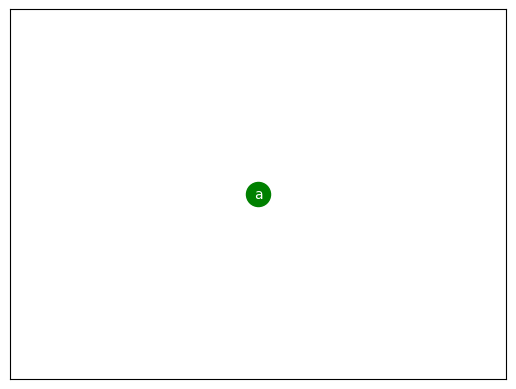

In [ ]:
res, _ = lhs_to_graph("a[x=5]", condition)
expected = _create_graph([('a', {'x':None})], [])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

res, _ = lhs_to_graph("a-[x=5]->b", condition)
expected = _create_graph(['a', 'b'], [('a','b',{'x':None})])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

res, _ = lhs_to_graph("a<1,2>[x=5, y: int = 6]", condition)
expected = _create_graph([('a<1,2>',{'x':None, 'y':None})],[])
#assert(_graphs_equal(res,expected))
_plot_graph(res)

# res = lhs_to_graph("a[a]->b[ b ] -> c[ c ]")
# expected = _create_graph(['a','b','c'], [('a','b'),('b','c')])
# assert(_graphs_equal(expected, res))

### multiple patterns

In [ ]:
# res = lhs_to_graph("a->b -> c; c-> d")
# expected = _create_graph(['a','b','c','d'], [('a','b'),('b','c'),('c','d')])
# assert(_graphs_equal(expected, res))

# res = lhs_to_graph("a->b -> c; d")
# expected = _create_graph(['a','b','c', 'd'], [('a','b'),('b','c')])
# assert(_graphs_equal(expected, res))

# res = lhs_to_graph("a->b -> c; c[x=5]")
# expected = _create_graph(['a','b','c'], [('a','b'),('b','c')])
# expected.nodes["c"]["x"] = "default"
# assert(_graphs_equal(expected, res))

In [ ]:
# required_syntax =  """
# a -> b

# a -[x:int = ...]-> b

# a -> b[x:int = ...]

# a -> b -6+[weight:int]-> c -> d[value:int]
# d<0> -> e
# d<5> -> e

# b -+-> d[value:int]
# d<0> -7-> e
# e<0,5> -> _

# b[ \
# value: str = \"hello\", \
# id: int \
# ]

# b -[
# ...
# ]-> c 

# """